In [12]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import statsmodels.formula.api as smf
import missingno as msno 

# Baseline Model

## 1 Import Features
Here we use the feature table that we created in the data preperation.

In [13]:

features = pd.read_csv("../0_DataPreparation/features.csv")
pd.set_option('display.max_columns', None)
features

,id,Datum,Umsatz,Bewoelkung,Temperatur,Windgeschwindigkeit,Rain,KielerWoche,CPI,Unemployment,GDP,Rain_Sum_8to18,Rain_8to18,Temp_5d_avg,Temp_above_avg,Temp_below_avg,Tmax,Tmax_gt25,Hot_HeavyRain,Wochenende,Feiertag,Schulferien,Residual,Temperatureclass_enc,Cloudclass_enc,Windclass_enc,Group_Broetchen,Group_Brot,Group_Croissant,Group_Konditorei,Group_Kuchen,Group_Saisonbrot,Weather_After_Rain,Weather_Fog,Weather_Other,Weather_Rain,Weather_Showers_and_Thunderstorms,Weather_Snow_and_Ice,Weekday_0,Weekday_1,Weekday_2,Weekday_3,Weekday_4,Weekday_5,Weekday_6,Month_1,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12
0,1307011,2013-07-01,148.828353,6.0,17.8375,15.0,1.567431,0,93.5,6.8,728.23,1.442231,1,14.4575,1,0,18.199883,0,0,0,0,1,0,2,1,2,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,1307021,2013-07-02,159.793757,3.0,17.3125,10.0,0.140967,0,93.5,6.8,728.23,0.140967,0,15.4100,0,0,18.319065,0,0,0,0,1,0,2,1,2,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,1307031,2013-07-03,111.885594,7.0,21.0750,6.0,6.276774,0,93.5,6.8,728.23,5.542491,1,17.0150,1,0,22.473013,0,0,0,0,1,0,2,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,1307041,2013-07-04,168.864941,7.0,18.8500,7.0,0.126180,0,93.5,6.8,728.23,0.126180,0,17.8175,0,0,19.594244,0,0,0,0,1,0,2,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,1307051,2013-07-05,171.280754,5.0,19.9750,12.0,1.255988,0,93.5,6.8,728.23,1.255988,1,19.0100,0,0,20.406262,0,0,0,0,1,0,2,1,2,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11159,1812226,2018-12-22,NaN,8.0,4.3000,4.0,0.392234,0,98.5,4.9,881.52,0.243416,0,4.7575,0,0,5.505522,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
11160,1812236,2018-12-23,NaN,7.0,6.4500,9.0,4.244212,0,98.5,4.9,881.52,1.981295,1,4.9850,0,0,6.818994,0,0,1,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
11161,1812246,2018-12-24,NaN,7.0,2.5000,10.0,0.000000,0,98.5,4.9,881.52,0.000000,0,4.8500,0,0,4.503302,0,0,0,0,1,0,0,0,2,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
11162,1812276,2018-12-27,NaN,7.0,7.1250,12.0,0.000000,0,98.5,4.9,881.52,0.000000,0,6.0700,0,0,7.492173,0,0,0,0,1,0,1,0,2,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


## 2 Check for Missing Data
Just to make schure that there are no remaining gaps in the data

<Axes: >

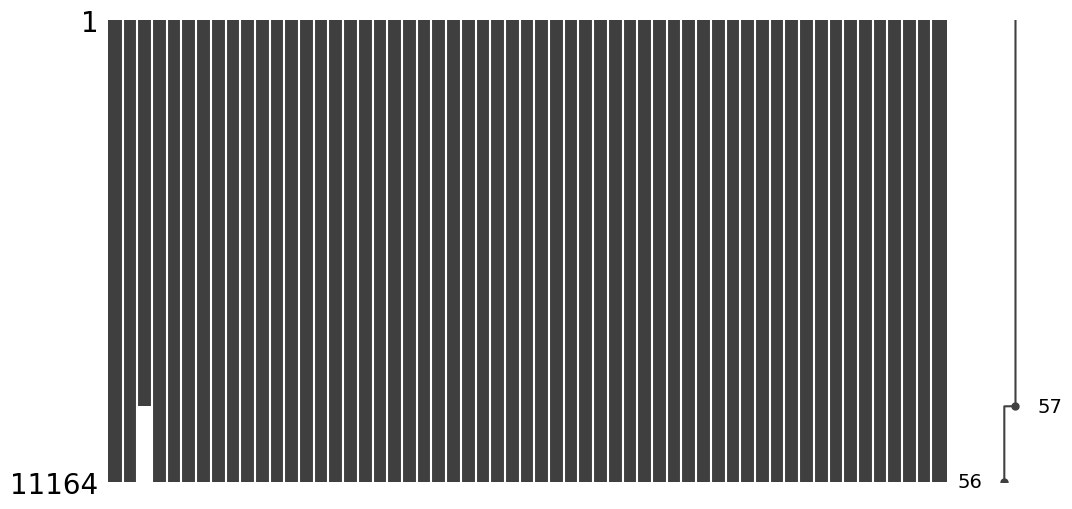

In [14]:
msno.matrix(features, figsize=(12, 6))

## 3 Time Split
We Split the dataset into training, validation and test data

In [15]:
train_end_date = '2017-07-31'
validation_end_date = '2018-07-31'


train_data = features[features['Datum']<=train_end_date].set_index("id")
vali_data = features[(features['Datum']> train_end_date) & (features['Datum']<=validation_end_date)].set_index("id")
test_data = features[(features['Datum']> validation_end_date)].set_index("id")



## 4 Feature Selection

To gain a broader understanding of which features might be important for the baseline model, we test different combinations of features. Therefore, we define several groups of feature combinations, which we fit against the sales data.

### Feature Groups

- **Time**: Variables related to time, such as the day of the week.  
- **Weather**: Variables related to weather measurements, such as temperature.  
- **Weather Stats**: Statistics related to the weather, such as temperature relative to the 5-day average.  
- **Weather Group**: Different types of weather conditions, such as rain.  
- **Product**: The different product groups that are sold.  
- **Economy**: Economic indicators, such as GDP.  
- **Holiday**: Public holidays and special events.  
- **Residual**: A flag for days with exceptionally high sales.


In [16]:
# Set 'id' as index
df = train_data

# Drop rows with missing values for simplicity in this baseline modeling
df_clean = df.dropna()

groups = {
    "Time": "Weekday_0 + Weekday_1 + Weekday_2 + Weekday_3 + Weekday_4 + Weekday_5 + Weekday_6 + Month_1 + Month_2 + Month_3 + Month_4 + Month_5 + Month_6 + Month_7 + Month_8 + Month_9 + Month_10 + Month_11 + Month_12 + Wochenende",
    "Weather": "C(Temperatureclass_enc) + C(Cloudclass_enc) + C(Windclass_enc) + Hot_HeavyRain",
    "Weather_Stats": "Rain_8to18 + Temp_above_avg + Temp_below_avg + Temp_5d_avg + Tmax + Tmax_gt25",
    "Weather_Group": "Weather_Other + Weather_Rain + Weather_After_Rain + Weather_Showers_and_Thunderstorms + Weather_Snow_and_Ice + Weather_Fog",
    "Product": "Group_Broetchen + Group_Brot + Group_Croissant + Group_Konditorei + Group_Kuchen + Group_Saisonbrot",
    "Economy": "CPI + Unemployment + GDP",
    "Holiday": "Schulferien + KielerWoche + Feiertag",
    "Residual": "Residual"
}



# 5 Evaluation


Wie define different combinations of features that we test agins each other.

In [17]:
# Define a list of formulas for different baseline models

formulas = {
    "TimeOnly": f"Umsatz ~ {groups['Time']}",
    "WeatherOnly": f"Umsatz ~ {groups['Weather']}",
    "WeatherWithStats": f"Umsatz ~ {groups['Weather']} + {groups['Weather_Stats']}",
    "ProductOnly": f"Umsatz ~ {groups['Product']}",
    "EconomyOnly": f"Umsatz ~ {groups['Economy']}",
    "Time_Weather": f"Umsatz ~ {groups['Time']} + {groups['Weather']}",
    "Time_WeatherStats": f"Umsatz ~ {groups['Time']} + {groups['Weather_Stats']}",
    "Time_Product": f"Umsatz ~ {groups['Time']} + {groups['Product']}",
    "Time_Economy": f"Umsatz ~ {groups['Time']} + {groups['Economy']}",
    "Time_Holiday": f"Umsatz ~ {groups['Time']} + {groups['Holiday']}",
    "Time_Weather_Product": f"Umsatz ~ {groups['Time']} + {groups['Weather']} + {groups['Product']}",
    "AllCoreFeatures": f"Umsatz ~ {groups['Time']} + {groups['Weather']} + {groups['Weather_Stats']} + {groups['Product']} + {groups['Economy']} + {groups['Holiday']}",
    "AllFeatures_WithWeatherGroups": f"Umsatz ~ {groups['Time']} + {groups['Weather']} + {groups['Weather_Stats']} + {groups['Weather_Group']} + {groups['Product']} + {groups['Economy']} + {groups['Holiday']}",
    "AllCoreFeatures_WithResidual": f"Umsatz ~ {groups['Time']} + {groups['Weather']} + {groups['Weather_Stats']} + {groups['Product']} + {groups['Economy']} + {groups['Holiday']} + {groups['Residual']}",
    "AllFeatures_WithWeatherGroups_Residual": f"Umsatz ~ {groups['Time']} + {groups['Weather']} + {groups['Weather_Stats']} + {groups['Weather_Group']} + {groups['Product']} + {groups['Economy']} + {groups['Holiday']} + {groups['Residual']}"
}

# Fit models and collect performance metrics
results = []
for name, formula in formulas.items():
    model = smf.ols(formula, data=df_clean).fit()
    results.append({
        "Modell": name,
        "R²": round(model.rsquared, 4),
        "Adj. R²": round(model.rsquared_adj, 4),  
        # "AIC": round(model.aic, 2),
        # "BIC": round(model.bic, 2),
        "Anzahl Parameter": int(model.df_model + 1)
    })

# Convert results to DataFrame
results_df = pd.DataFrame(results).sort_values(by="R²", ascending=False)
results_df

,Modell,R²,Adj. R²,Anzahl Parameter
14,AllFeatures_WithWeatherGroups_Residual,0.8115,0.8103,48
13,AllCoreFeatures_WithResidual,0.8114,0.8103,43
11,AllCoreFeatures,0.7550,0.7536,42
12,AllFeatures_WithWeatherGroups,0.7550,0.7535,47
10,Time_Weather_Product,0.7363,0.7353,30
7,Time_Product,0.7355,0.7347,23
3,ProductOnly,0.6506,0.6503,6
9,Time_Holiday,0.1104,0.1080,21
8,Time_Economy,0.1058,0.1034,21
6,Time_WeatherStats,0.0989,0.0962,24


# 6 Evaluation Results

The best-performing model in terms of **R² score** was **Model_AllFeatures_WithWeatherGroups_Residual**, which includes all available feature groups—such as time, weather (including weather state groups), product categories, economic indicators, holidays, and residual flags. 

However, we observed that the addition of the **weather group features** (describing specific weather states like rain, fog, etc.) led to only **marginal improvements in R²** compared to a simpler model.

Therefore, we select **Model_AllCoreFeatures_WithResidual** as our **baseline model**, as it provides the best trade-off between model simplicity and predictive performance. It includes all core feature groups plus the residual indicator, making it both interpretable and robust.



# 7 Create the baseline model

In [18]:
model = smf.ols(formulas['AllCoreFeatures_WithResidual'], data=train_data.dropna()).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Umsatz   R-squared:                       0.811
Model:                            OLS   Adj. R-squared:                  0.810
Method:                 Least Squares   F-statistic:                     763.1
Date:                Thu, 31 Jul 2025   Prob (F-statistic):               0.00
Time:                        07:39:16   Log-Likelihood:                -41815.
No. Observations:                7493   AIC:                         8.372e+04
Df Residuals:                    7450   BIC:                         8.401e+04
Df Model:                          42                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                       26.8925    207.002      0.130      0.897    -378.890     432.674
C(Temperatureclass_enc)[T.1]     0.0422      3.199      0.013      0.989      -6.229       6.314
C(Temperatureclass_enc)[T.2]     6.5382      5.307      1.232      0.218      -3.866      16.942
C(Temperatureclass_enc)[T.3]    -3.9055      9.658     -0.404      0.686     -22.838      15.027
C(Cloudclass_enc)[T.1]           2.4915      1.741      1.431      0.153      -0.922       5.905
C(Windclass_enc)[T.1]            3.5896      4.284      0.838      0.402      -4.809      11.988
C(Windclass_enc)[T.2]            0.8328      1.589      0.524      0.600      -2.281       3.947
Weekday_0                       -2.4963     36.594     -0.068      0.946     -74.230      69.237
Weekday_1                       -4.8381     36.558     -0.132      0.895     -76.502      66.826
Weekday_2                       -4.9901     36.551     -0.137      0.891     -76.640      66.660
Weekday_3                        0.2269     36.568      0.006      0.995     -71.456      71.910
Weekday_4                        3.9600     36.583      0.108      0.914     -67.752      75.672
Weekday_5                       12.9761     12.270      1.058      0.290     -11.077      37.029
Weekday_6                       22.0541     12.274      1.797      0.072      -2.006      46.114
Month_1                        -32.9864     20.701     -1.593      0.111     -73.567       7.594
Month_2                         -9.3773     20.927     -0.448      0.654     -50.401      31.646
Month_3                        -21.0269     19.749     -1.065      0.287     -59.741      17.687
Month_4                        -13.1617     17.912     -0.735      0.462     -48.275      21.952
Month_5                          4.0009     16.508      0.242      0.809     -28.359      36.361
Month_6                         12.0786     16.389      0.737      0.461     -20.048      44.205
Month_7                         46.9117     18.166      2.582      0.010      11.301      82.523
Month_8                         62.1803     18.541      3.354      0.001      25.836      98.525
Month_9                          8.2275     16.710      0.492      0.622     -24.529      40.984
Month_10                         3.6765     15.579      0.236      0.813     -26.862      34.215
Month_11                       -15.1815     14.853     -1.022      0.307     -44.297      13.934
Month_12                       -18.4493     16.484     -1.119      0.263     -50.762      13.864
Wochenende                      35.0302     24.385      1.437      0.151     -12.772      82.832
Hot_HeavyRain                   18.0042     15.567      1.157      0.247     -12.511      48.520
Rain_8to18                      -4.3556      1.841     -2.366      0.018    

# Make a prediction for keggle


In [20]:
pred = model.predict(test_data).clip(lower=0)
pred_df = pred.rename("Umsatz").reset_index()
pred_df.to_csv("kaggle_baseline.csv", index=False)
